In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import ace_tools as tools  # For displaying the DataFrame

In [ ]:
# Load the dataset (Assuming it's in CSV format)
dataset_path = "dataset/data.csv"  # Replace with your actual file path
df = pd.read_csv(dataset_path)

# Display the first few rows to check the structure
print("Dataset Head:")
print(df.head())

# Check the column names to ensure the "subject" column exists
print("\nAvailable Columns:", df.columns)

# Filter the dataset to keep only Biology questions
biology_df = df[df["subject"] == "Biology"]

# Save the filtered dataset
filtered_dataset_path = "dataset/biology_questions.csv"
biology_df.to_csv(filtered_dataset_path, index=False)

print(f"\nFiltered Biology dataset saved as: {filtered_dataset_path}")

In [11]:
dataset_path = "dataset/biology_questions.csv"  # Replace with your actual path
df = pd.read_csv(dataset_path)

# 1️⃣ Check the first few rows
print("Dataset Preview:")
print(df.head())

Dataset Preview:
                                                 eng  Subject
0  An anti-forest measure is\nA. Afforestation\nB...  Biology
1  In recent year, there has been a growing\nconc...  Biology
2  Fern plants reproduce by\nA. Seeds\nB. Spores\...  Biology
3     Write an essay on growth regulation in plants.  Biology
4  What is the function of pericardial fluid and ...  Biology


In [12]:
# 2️⃣ Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values Per Column:\n", missing_values)



Missing Values Per Column:
 eng        0
Subject    0
dtype: int64


In [13]:
# 3️⃣ Check data types
print("\nColumn Data Types:")
print(df.dtypes)


Column Data Types:
eng        object
Subject    object
dtype: object


In [14]:
# 4️⃣ Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"\nTotal Duplicate Rows: {duplicate_count}")


Total Duplicate Rows: 30


In [15]:
# 5️⃣ Summary statistics for categorical columns
print("\nSummary Statistics for Categorical Columns:")
print(df.describe(include=["O"]))  # "O" refers to object (categorical) type columns



Summary Statistics for Categorical Columns:
                                                      eng  Subject
count                                               13124    13124
unique                                              13094        1
top     Carotid artery supplies\nA. Oxygenated blood t...  Biology
freq                                                    2    13124


In [17]:
# 6️⃣ Unique values in key columns
columns_to_check = ["Subject"]
for col in columns_to_check:
    print(f"\nUnique values in '{col}': {df[col].nunique()}")
    print(df[col].unique())


Unique values in 'Subject': 1
['Biology']


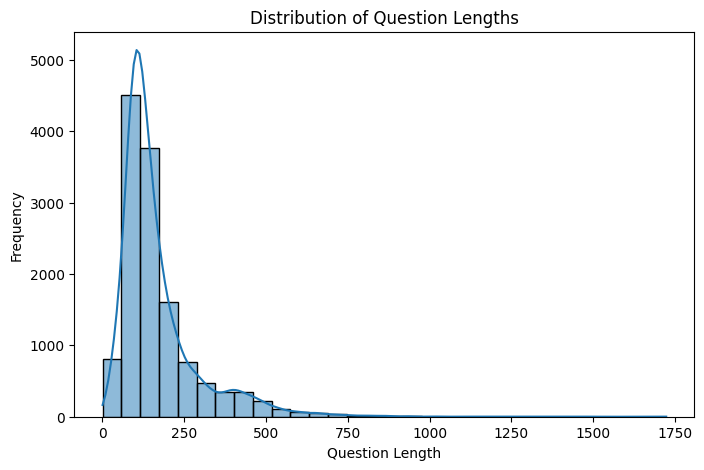

In [19]:
# 9️⃣ Text Length Analysis (Question Length Distribution)
df["question_length"] = df["eng"].apply(lambda x: len(str(x)))
plt.figure(figsize=(8, 5))
sns.histplot(df["question_length"], bins=30, kde=True)
plt.title("Distribution of Question Lengths")
plt.xlabel("Question Length")
plt.ylabel("Frequency")
plt.show()

In [20]:
df.iloc[0]

eng                An anti-forest measure is\nA. Afforestation\nB...
Subject                                                      Biology
question_length                                                  104
Name: 0, dtype: object

In [22]:
import pandas as pd
import re

# Load dataset
dataset_path = "dataset/biology_questions.csv"  # Replace with actual file path
df = pd.read_csv(dataset_path)

# Function to extract question and options
def extract_question_options(text):
    # Define regex pattern to match options (A., B., C., ...)
    pattern = r"\n([A-J])\.\s*"  

    # Find all option markers (A., B., C., etc.)
    matches = list(re.finditer(pattern, text))

    if not matches:
        return text, {}  # Return full text as question if no options are found

    # Extract question (before first option)
    question = text[: matches[0].start()].strip()

    # Extract options
    options = {}
    for i in range(len(matches)):
        option_letter = matches[i].group(1)  # Get the letter (A, B, C, etc.)
        start_pos = matches[i].end()  # Start position of option text
        end_pos = matches[i + 1].start() if i + 1 < len(matches) else len(text)  # End position

        options[option_letter] = text[start_pos:end_pos].strip()  # Store option text

    return question, options

# Apply function to dataset
questions = []
options_dicts = []

for text in df["eng"]:
    question, options = extract_question_options(text)
    questions.append(question)
    options_dicts.append(options)

# Convert options dictionary to DataFrame
options_df = pd.DataFrame(options_dicts).fillna("")

# Merge with original dataset
df_cleaned = df.copy()
df_cleaned["Question"] = questions
df_cleaned = pd.concat([df_cleaned, options_df], axis=1)

# Drop original "eng" column
df_cleaned = df_cleaned.drop(columns=["eng"])

# Save the cleaned dataset
cleaned_dataset_path = "biology_questions_cleaned.csv"
df_cleaned.to_csv(cleaned_dataset_path, index=False)
print(f"\nCleaned dataset saved as: {cleaned_dataset_path}")



Cleaned dataset saved as: biology_questions_cleaned.csv


In [2]:
from langchain_community.document_loaders import PDFMinerLoader

loader = PDFMinerLoader("dataset/data/kebo101.pdf")
data = loader.load()

In [1]:
import re
import logging
from langchain.text_splitter import TokenTextSplitter
from langchain.schema import Document

# Setup logging
logging.basicConfig(filename="logs/text_processing.log", level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

class TextProcessor:
    def __init__(self, encoding="gpt2", chunk_size=512, chunk_overlap=100):
        """
        Initializes text processor with TokenTextSplitter.
        """
        self.text_splitter = TokenTextSplitter(
            encoding_name=encoding,
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap
        )
        logging.info(f"✅ Initialized TokenTextSplitter with chunk_size={chunk_size}, chunk_overlap={chunk_overlap}")

    def extract_metadata(self, text):
        """
        Extracts metadata such as chapter number, chapter name, and section titles.
        """
        try:
            # Find Chapter Number
            chapter_match = re.search(r"Chapter\s+(\d+)", text, re.IGNORECASE)
            chapter_number = chapter_match.group(1) if chapter_match else "Unknown"

            # Find Chapter Name (line after "Chapter X")
            chapter_name_match = re.search(rf"Chapter\s+{chapter_number}\s*\n(.*?)\n", text, re.IGNORECASE)
            chapter_name = chapter_name_match.group(1).strip() if chapter_name_match else "Unknown"

            # Find Section Titles (e.g., 2.1, 2.2, or "Introduction")
            section_match = re.search(r"(\d+\.\d+|Introduction|Summary)", text, re.IGNORECASE)
            section_title = section_match.group(0) if section_match else "General"

            return {"chapter": chapter_number, "chapter_name": chapter_name, "section": section_title}

        except Exception as e:
            logging.error(f"❌ Error extracting metadata: {str(e)}", exc_info=True)
            return {"chapter": "Unknown", "chapter_name": "Unknown", "section": "General"}

    def split_text(self, text):
        """
        Splits cleaned text into smaller token-based chunks with metadata.
        """
        try:
            metadata = self.extract_metadata(text)
            cleaned_text = self.clean_text(text)
            chunks = self.text_splitter.split_text(cleaned_text)

            # Convert chunks into `Document` objects with metadata
            doc_chunks = [Document(page_content=chunk, metadata=metadata) for chunk in chunks]

            logging.info(f"✅ Successfully split text into {len(doc_chunks)} chunks with metadata.")
            return doc_chunks
        except Exception as e:
            logging.error(f"❌ Failed to split text: {str(e)}", exc_info=True)
            return []


In [5]:
tt = TextProcessor()

In [6]:
text = """  
C HAPTER 1
1.1 Diversity in the
Living World
1.2 Taxonomic
Categories
2024-25
4 BIOLOGY
types of organisms present on earth. We should remember here that as
we explore new areas, and even old ones, new organisms are continuously
being identified.
As stated earlier, there are millions of plants and animals in the world;
we know the plants and animals in our own area by their local names.
These local names would vary from place to place, even within a country.
Probably you would recognise the confusion that would be created if we
did not find ways and means to talk to each other, to refer to organisms
we are talking about.
Hence, there is a need to standardise the naming of living organisms
such that a particular organism is known by the same name all over the
world. This process is called nomenclature. Obviously, nomenclature
or naming is only possible when the organism is described correctly and
we know to what organism the name is attached to. This isidentification.
In order to facilitate the study, number of scientists have established
procedures to assign a scientific name to each known organism. This is
acceptable to biologists all over the world. For plants, scientific names are
based on agreed principles and criteria, which are provided in International
Code for Botanical Nomenclature (ICBN). You may ask, how are animals
named? Animal taxonomists have evolved International Code of Zoological
Nomenclature (ICZN). The scientific names ensure that each organism
has only one name. Description of any organism should enable the people
(in any part of the world) to arrive at the same name. They also ensure
that such a name has not been used for any other known organism.
Biologists follow universally accepted principles to provide scientific
names to known organisms. Each name has two components – the
Generic name and the specific epithet. This system of providing a
name with two components is called Binomial nomenclature. This
naming system given by Carolus Linnaeus is being practised by biologists
all over the world. This naming system using a two word format was
found convenient. Let us take the example of mango to understand the
way of providing scientific names better. The scientific name of mango is
written as Mangifera indica. Let us see how it is a binomial name. In this
name Mangifera represents the genus while indica, is a particular species,
or a specific epithet. Other universal rules of nomenclature are as follows:
1. Biological names are generally in Latin and written in italics.
They are Latinised or derived from Latin irrespective of their
origin.
2. The first word in a biological name represents the genus while
the second component denotes the specific epithet.
3. Both the words in a biological name, when handwritten, are
separately underlined, or printed in italics to indicate their Latin
origin.
2024-25
THE LIVING WORLD 5
4. The first word denoting the genus starts with a capital letter
while the specific epithet starts with a small letter. It can be
illustrated with the example of Mangifera indica.
Name of the author appears after the specific epithet, i.e., at the end of
the biological name and is written in an abbreviated form, e.g., Mangifera
indica Linn. It indicates that this species was first described by Linnaeus.
Since it is nearly impossible to study all the living organisms, it is
necessary to devise some means to make this possible. This process is
classification. Classification is the process by which anything is grouped
into convenient categories based on some easily observable characters.
For example, we easily recognise groups such as plants or animals or
dogs, cats or insects. The moment we use any of these terms, we associate
certain characters with the organism in that group. What image do you
see when you think of a dog ? Obviously, each one of us will see ‘dogs’
and not ‘cats’. Now, if we were to think of ‘Alsatians’ we know what we are
talking about. Similarly, suppose we were to say ‘mammals’, you would,
of course, think of animals with external ears and body hair. Likewise, in
plants, if we try to talk of ‘Wheat’, the picture in each of our minds will be
of wheat plants, not of rice or any other plant. Hence, all these - ‘Dogs’,
‘Cats’, ‘Mammals’, ‘Wheat’, ‘Rice’, ‘Plants’, ‘Animals’, etc., are convenient
categories we use to study organisms. The scientific term for these
categories is taxa. Here you must recognise that taxa can indicate
categories at very different levels. ‘Plants’ – also form a taxa. ‘Wheat’ is
also a taxa. Similarly, ‘animals’, ‘mammals’, ‘dogs’ are all taxa – but you
know that a dog is a mammal and mammals are animals. Therefore,
‘animals’, ‘mammals’ and ‘dogs’ represent taxa at different levels.
Hence, based on characteristics, all living organisms can be classified
into different taxa. This process of classification is taxonomy. External
and internal structure, along with the structure of cell, development
process and ecological information of organisms are essential and form
the basis of modern taxonomic studies.
Hence, characterisation, identification, classification and nomenclature
are the processes that are basic to taxonomy.
Taxonomy is not something new. Human beings have always been
interested in knowing more and more about the various kinds of
organisms, particularly with reference to their own use. In early days,
human beings needed to find sources for their basic needs of food, clothing
and shelter. Hence, the earliest classifications were based on the ‘uses’ of
various organisms.
Human beings were, since long, not only interested in knowing more
about different kinds of organisms and their diversities, but also the
relationships among them. This branch of study was referred to as
systematics. The word systematics is derived from the Latin word
‘systema’ which means systematic arrangement of organisms. Linnaeus
2024-25
6 BIOLOGY
used Systema Naturae as the title of his publication. The scope of
systematics was later enlarged to include identification, nomenclature
and classification. Systematics takes into account evolutionary
relationships between organisms.
1.2 TAXONOMIC CATEGORIES
Classification is not a single step process but involves hierarchy of steps
in which each step represents a rank or category. Since the category is a
part of overall taxonomic arrangement, it is called the taxonomic category
and all categories together constitute the taxonomic hierarchy. Each
category, referred to as a unit of classification, in fact, represents a rank
and is commonly termed as taxon (pl.: taxa).
Taxonomic categories and hierarchy can be illustrated by an example.
Insects represent a group of organisms sharing common features like
three pairs of jointed legs. It means insects are recognisable concrete
objects which can be classified, and thus were given a rank or category.
Can you name other such groups of organisms? Remember, groups
represent category. Category further denotes rank. Each rank or taxon,
in fact, represents a unit of classification. These taxonomic groups/
categories are distinct biological entities and not merely morphological
aggregates.
Taxonomical studies of all known organisms have led to the
development of common categories such as kingdom, phylum or division
(for plants), class, order, family, genus and species. All organisms,
including those in the plant and animal kingdoms have species as the
lowest category. Now the question you may ask is, how to place an
organism in various categories? The basic requirement is the knowledge
of characters of an individual or group of organisms. This helps in
identifying similarities and dissimilarities among the individuals of the
same kind of organisms as well as of other kinds of organisms.
1.2.1 Species
Taxonomic studies consider a group of individual organisms with
fundamental similarities as a species. One should be able to distinguish
one species from the other closely related species based on the distinct
morphological differences. Let us consider Mangifera indica, Solanum
tuberosum (potato) and Panthera leo (lion). All the three names, indica,
tuberosum and leo, represent the specific epithets, while the first words
Mangifera, Solanum and Panthera are genera and represents another
higher level of taxon or category. Each genus may have one or more than
one specific epithets representing different organisms, but having
morphological similarities. For example, Panthera has another specific
epithet called tigris and Solanum includes species like nigrum and
2024-25
THE LIVING WORLD 7
melongena. Human beings belong to the species sapiens which is grouped
in the genus Homo. The scientific name thus, for human being, is written
as Homo sapiens.
1.2.2 Genus
Genus comprises a group of related species which has more characters
in common in comparison to species of other genera. We can say that
genera are aggregates of closely related species. For example, potato and
brinjal are two different species but both belong to the genus Solanum.
Lion (Panthera leo), leopard (P. pardus) and tiger (P. tigris) with several
common features, are all species of the genus Panthera. This genus differs
from another genus Felis which includes cats.
1.2.3 Family
The next category, Family, has a group of related genera with still less
number of similarities as compared to genus and species. Families are
characterised on the basis of both vegetative and reproductive features of
plant species. Among plants for example, three different genera Solanum,
Petunia and Datura are placed in the family Solanaceae. Among animals
for example, genus Panthera, comprising lion, tiger, leopard is put along
with genus, Felis (cats) in the family Felidae. Similarly, if you observe the
features of a cat and a dog, you will find some similarities and some
differences as well. They are separated into two different families – Felidae
and Canidae, respectively.
1.2.4 Order
You have seen earlier that categories like species, genus and families are
based on a number of similar characters. Generally, order and other
higher taxonomic categories are identified based on the aggregates of
characters. Order being a higher category, is the assemblage of families
which exhibit a few similar characters. The similar characters are less in
number as compared to different genera included in a family. Plant
families like Convolvulaceae, Solanaceae are included in the order
Polymoniales mainly based on the floral characters. The animal order,
Carnivora, includes families like Felidae and Canidae.
1.2.5 Class
This category includes related orders. For example, order Primata
comprising monkey, gorilla and gibbon is placed in class Mammalia along
with order Carnivora that includes animals like tiger, cat and dog. Class
Mammalia has other orders also.
1.2.6 Phylum
Classes comprising animals like fishes, amphibians, reptiles, birds along
with mammals constitute the next higher category called Phylum. All
2024-25
8 BIOLOGY
these, based on the common features like presence of notochord
and dorsal hollow neural system, are included in phylum
Chordata. In case of plants, classes with a few similar characters
are assigned to a higher category called Division.
1.2.7 Kingdom
All animals belonging to various phyla are assigned to the
highest category called Kingdom Animalia in the classification
system of animals. The Kingdom Plantae, on the other hand, is
distinct, and comprises all plants from various divisions.
Henceforth, we will refer to these two groups as animal and
plant kingdoms.
The taxonomic categories from species to kingdom have been
shown in ascending order starting with species in Figure 1.1.
These are broad categories. However, taxonomists have also
developed sub-categories in this hierarchy to facilitate more
sound and scientific placement of various taxa.
Look at the hierarchy in Figure 1.1. Can you recall the basis
of arrangement? Say, for example, as we go higher from species
to kingdom, the number of common characteristics goes on
decreasing. Lower the taxa, more are the characteristics that the
members within the taxon share. Higher the category, greater is
the difficulty of determining the relationship to other taxa at the
same level. Hence, the problem of classification becomes more
complex.
Table 1.1 indicates the taxonomic categories to which some
common organisms like housefly, man, mango and wheat belong.
Figure 1.1 T a x o n o m i c
c a t e g o r i e s
s h o w i n g
h i e r a r c h i a l
arrangement
in ascending
order
Common Biological Genus Family Order Class Phylum/
Name Name Division
Man Homo sapiens Homo Hominidae Primata Mammalia Chordata
Housefly Musca Musca Muscidae Diptera Insecta Arthropoda
domestica
Mango Mangifera Mangifera Anacardiaceae Sapindales Dicotyledonae Angiospermae
indica
Wheat Triticum Triticum Poaceae Poales Monocotyledonae Angiospermae
aestivum
TABLE 1.1 Organisms with their Taxonomic Categories
2024-25
THE LIVING WORLD 9
S UMMARY
The living world is rich in variety. Millions of plants and animals have been
identified and described but a large number still remains unknown. The
very range of organisms in terms of size, colour, habitat, physiological and
morphological features make us seek the defining characteristics of living
organisms. In order to facilitate the study of kinds and diversity of organisms,
biologists have evolved certain rules and principles for identification,
nomenclature and classification of organisms. The branch of knowledge
dealing with these aspects is referred to as taxonomy. The taxonomic studies
of various species of plants and animals are useful in agriculture, forestry,
industry and in general for knowing our bio-resources and their diversity.
The basics of taxonomy like identification, naming and classification of
organisms are universally evolved under international codes. Based on the
resemblances and distinct differences, each organism is identified and
assigned a correct scientific/biological name comprising two words as per
the binomial system of nomenclature. An organism represents/occupies a
place or position in the system of classification. There are many categories/
ranks and are generally referred to as taxonomic categories or taxa. All the
categories constitute a taxonomic hierarchy.
"""

In [8]:
print(tt.extract_metadata(text))

{'chapter': 'Unknown', 'chapter_name': 'Unknown', 'section': '1.1'}
